# Simulator and Random Walks

## Initialization of a dynamic model
The library includes a module (RNSRW) that allows the simulation of reaction networks under mass action law kinbetics. This module also allows to perturb the reaction network in different ways. As well as simulating a random walk, where each step consists of a simulation given a convergence time, which is then perturbed in different ways.  As useal in first intace we load the libray:

In [1]:
import sys
!{sys.executable} -m pip install ../. --quiet --user #installation of library in local enviorment
from pyRN import pyRN
import numpy as np

Once a network has been initialized using the `setRandomgeneratedWhitInflow()` function, a mass action kinetic model can be initialized using the `setMakModel()` function: 

In [2]:
RN=pyRN.setRandomgeneratedWithInflow()
RN.setMakModel(i_sp=None,rt=None,cutoff=0.1)

The initialization parameters correspond to:

- `i_sp`: Initial concentration according to the order of occurrence sp
- `rt`: Kinetic constants as a function of the reaction partitioning in the stoichiometric matrix.
- `cutoff`: Is the concentration value when species are considered to not be present

If this inputs are not given (`None` values), they are inizialized by a uniform distribution in the interval [0,1].The dynamic model is inherited from the `roadruner` library, a python library for dynamic stability analysis in sbml models. 

The model can also be initialized from two text files using the `setMakModelFromFile()` function. The `SpConFname` argument corresponds to the file containing initial concentrations of the species, while the `KConstFname` argument corresponds to the name of the file containing the kinetic constants. The `cutoff` argument is inherited from the `setMakModel()` function. If the `SpConFname` or/and `KConstFname` argument is not given (`None` value), it randomly initializes the initial conditions according to a uniform distribution between zero and one.

In [3]:
RN.setMakModelFromFile(SpConFileNameStr=None ,KConstFileNameStr=None ,cutoff=0.1)

The `saveInitCondToText()` function can be used to save the initial species concentration variables as well as the kinetic constants of the model to a file so that they can be extracted for future use. Its arguments are `SpConFilename` and `KConstFilename` which correspond to the filenames of the concentrations and kinetic constants respectively. If these arguments are not given to the function (Noe values) it creates these by default as the network filename plus a pseudonym describing the file type i.e.:
- `KConstFilename` ="Network name+"KConst.txt"
- `SpConFilename`="Network name"+"SpCon.txt"

In [4]:
RN.saveToText("../networks/RandGen.txt")
RN.saveInitCondToText(SpConFileNameStr=None,KConstFileNameStr=None)

After inizializing the model , the model then can be simulate by the folowing function:

In [5]:
RN.runMakModel(ti=0,tf=50,steps=100,cutoff=0.1)

This function receives as input the initial time `ti`, the final time `tf`, and the number of `steps` in the simulation. The variable `cutoff` corresponds to the concentration of species in which they are considered as inexistent, i.e. zero.The function generates member objects describing the concentrations (`SpConDf`) of the species, the rates of the reactions (`RpRateDf`). 

In [6]:
RN.SpConDf

,s01,s03,s04,s05,s06,s07,s08,s10,s11,s12
time,,,,,,,,,,
0.0,0.334572,0.812583,0.526986,0.270808,0.863293,0.000000,0.912044,0.446494,0.464942,0.740909
0.5,0.501924,0.737645,0.350385,0.518231,0.854609,0.344211,0.734229,0.541313,0.389523,0.444463
1.0,0.635135,0.755084,0.223617,0.612696,0.870204,0.487741,0.596003,0.508663,0.311061,0.312607
1.5,0.752234,0.827047,0.141692,0.627006,0.885018,0.571687,0.477671,0.446901,0.249120,0.240528
2.0,0.856883,0.927256,0.000000,0.614046,0.895114,0.624722,0.373570,0.386354,0.202071,0.191975
...,...,...,...,...,...,...,...,...,...,...
48.0,1.238255,18.307400,0.000000,0.563271,0.908170,0.738485,0.000000,0.000000,0.000000,0.000000
48.5,1.238266,18.499234,0.000000,0.563269,0.908170,0.738485,0.000000,0.000000,0.000000,0.000000
49.0,1.238276,18.691069,0.000000,0.563266,0.908170,0.738485,0.000000,0.000000,0.000000,0.000000


In [7]:
RN.RpRateDf

,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13
time,,,,,,,,,,,,,,
0.0,0.000000,0.004904,0.348189,0.023963,0.135364,0.000000,0.407178,0.425985,0.088072,0.428991,0.031101,0.037136,0.777576,0.431999
0.5,0.052615,0.009385,0.231505,0.131649,0.081203,0.053365,0.241804,0.311307,0.204331,0.257347,0.020712,0.026065,0.777576,0.361924
1.0,0.070058,0.011096,0.147747,0.232858,0.057113,0.045348,0.173173,0.258675,0.227006,0.181001,0.011041,0.016622,0.777576,0.289021
1.5,0.072145,0.011355,0.093619,0.288823,0.043944,0.029590,0.135512,0.227075,0.204101,0.139267,0.005409,0.010661,0.777576,0.231469
2.0,0.068157,0.011121,0.000000,0.315544,0.035074,0.000000,0.109392,0.199105,0.172802,0.111155,0.000000,0.007015,0.777576,0.187754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48.0,0.000000,0.010201,0.000000,0.383690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.777576,0.000000
48.5,0.000000,0.010201,0.000000,0.383690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.777576,0.000000
49.0,0.000000,0.010201,0.000000,0.383690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.777576,0.000000


Abstractions can be obtained from by use of the `getAbstDf()` function. It returns a dataframe of different types of abstractions, considering if there are changes or not en echa case. The function are recives as input a `cutoff`, if in not given (`cutoff=None`) it will be initialized using the cutoff of the simulation model. The type of abastraction can be defined by the `abst_type` string variables in consideratrion of `cutoff`:
- `non_null` Species over the `cutoff`
- `close_abst` Closure of species over the `cutoff`
- `active_species` Active species (Considers reactant over the `cutoff` and triggerable productos)
- `active_reaction` Active reaction releted to the active species

In [8]:
RN.getAbstracDf(abst_type="non_null", cutoff=None)

,s01,s03,s04,s05,s06,s07,s08,s10,s11,s12
time,,,,,,,,,,
0.0,True,True,True,True,True,False,True,True,True,True
2.0,True,True,False,True,True,True,True,True,True,True
4.0,True,True,False,True,True,True,False,True,False,False
6.5,True,True,False,True,True,True,False,False,False,False


In [9]:
RN.getAbstracDf(abst_type="close_abst", cutoff=None)

,s01,s03,s04,s05,s06,s07,s08,s10,s11,s12
time,,,,,,,,,,
0.0,True,True,True,True,True,True,True,True,True,True
2.0,True,True,False,True,True,True,True,True,True,True
4.0,True,True,False,True,True,True,True,True,True,True
6.5,True,True,False,True,True,True,True,False,True,False


In [10]:
RN.getAbstracDf(abst_type="active_species", cutoff=None)

,s01,s03,s04,s05,s06,s07,s08,s10,s11,s12
time,,,,,,,,,,
0.0,True,True,True,True,True,True,True,True,True,True
2.0,True,True,False,True,True,True,True,True,True,True
4.0,True,True,False,True,True,True,False,True,True,True
6.5,True,True,False,True,False,False,False,False,True,False


In [11]:
RN.getAbstracDf(abst_type="active_reactions", cutoff=None)

,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13
time,,,,,,,,,,,,,,
0.0,False,True,True,True,True,False,True,True,True,True,True,True,True,True
2.0,True,True,False,True,True,False,True,True,True,True,False,True,True,True
4.0,True,True,False,True,False,False,False,False,True,False,False,False,True,False
6.5,False,True,False,True,False,False,False,False,False,False,False,False,True,False


Also the complexity of an abstraction `dataframe` can be obtained through the use of the `getComplexityArray()` function. This function returns a `array` with the complexity of each row of the `dataframe` corresponding to the abstraction. It takes as arguments `abst_type`, which can be `"species"` or `"reactions"`, and `elem_type`, which can be `"basics"` or `"generators"`. For this function to run correctly it is necessary to run the `getGenerators()` function first.

In [12]:
active_sp=RN.getAbstracDf(abst_type="active_species", cutoff=None)
RN.setGenerators()
print(RN.getComplexityArray(active_sp,abst_type="species",elem_type="basics"))

[6.         5.60833333 4.57222222 3.14444444]


All the above mentioned variables correspond to pandas dataframes, therefore they are easily plotted by means of the plot function.

<AxesSubplot: xlabel='time'>

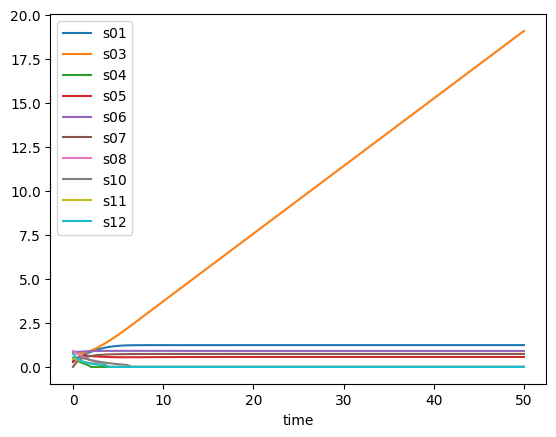

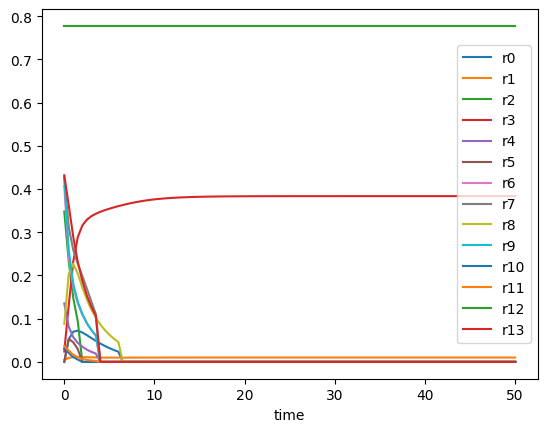

In [13]:
RN.SpConDf.plot()
RN.RpRateDf.plot()

Concentrations and rates can be changed using the `setMakParam()` function. Inputs are transitive from the `setMakModel()` function. The difference here is that the final values are changed, i.e. at the times left in the simulation. Thus the simulation can be continued from the previous point where it was left off, i.e. `tf`. Now if the variable init is `True`, the model returns to the initial state, i.e. it starts from `ti`.

<AxesSubplot: xlabel='time'>

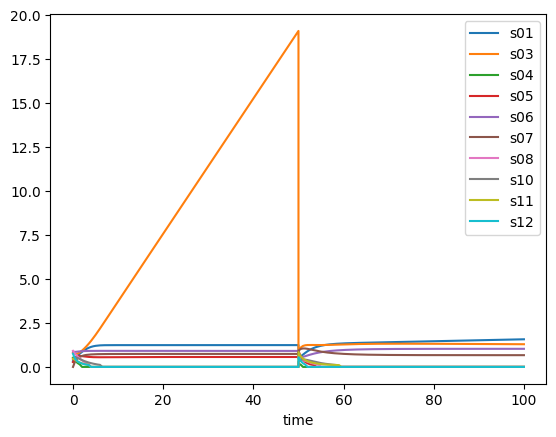

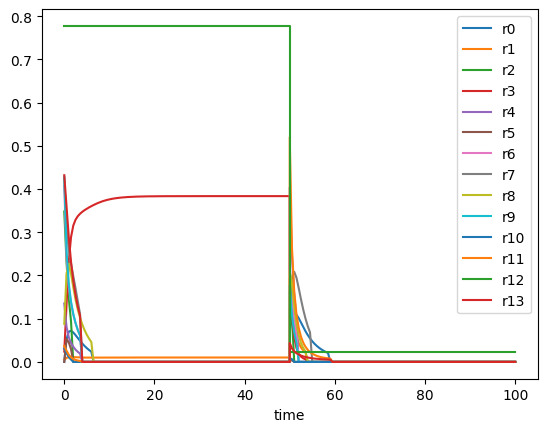

In [14]:
i_sp=np.random.uniform(size=RN.MrDf.shape[0]) #generation of random species concentration from a uniform distribution
rt=np.random.uniform(size=RN.MrDf.shape[1]) #generation of random kinetic costants concentration from a uniform distribution
RN.setMakParam(i_sp=i_sp,rt=rt,init=False) # changing the paraeters of the model
RN.runMakModel(50,100,100) # runing the model from the last simulating point
RN.SpConDf.plot()
RN.RpRateDf.plot()

Analogously to the initialization of models by means of the function setMakModelFromFile(), the function setMakParamFromFile() allows the change of parameters from files. The arguments correspond to the files containing the kinetic constants (KConstFname) and initial species concentrations (SpConFname).  

In [15]:
SpConFileNameStr=RN.SpConFileNameStr
print("Species initial concentration file: ",SpConFileNameStr)
KConstFileNameStr=RN.KConstFileNameStr
print("Kinetics constans file: ",KConstFileNameStr)
RN.setMakParamFromFile(SpConFileNameStr, KConstFileNameStr, init=True)

Species initial concentration file:  ../networks/RandGenSpCon.txt
Kinetics constans file:  ../networks/RandGenKConst.txt


The library contains a set of perturbation functions that act on `np.array` vectors. So they can be used in the imputs of `setMakParam()` function and keep track of a random walk in time. There are two perturbation functions, `getPertActivation()` and `getStatePert()`. The first one generates the activation or deactivation of components of the vector whose values are zeros, these can be understood as a structural perturbation, since in both cases reactions as species generate the appearance of interactions. The second function corresponds to a state perturbation for the case of species and to a process perturbation for the case of a vector of kinetic constants. The `getPertActivation()` function consists of the following input parameters:

- `v`: changing values from 0 to 1 or from >0 to 0 
- `mask`: which of the species will be changed (defaults to all components) 
- `n` total active components required (defaults is the number of `mask` elements), up to `p` active components to be preserved (defaults to all active components)

The function returns perturbed vector. 

While the function `getStatePert()`, receives as input:
- `v`: vector perturbed 
- `eplison`: size of the perturbation respect norm of v 
- `mask`: which of the species will be changed (defaults to all components) 

It also returns the perturbed vector.

In [16]:
v=np.random.choice([0, 1], size=10)
print("original vector: ",v)
struc_pert=RN.getPertActivation(v=v,mask=None,n=None,p=None)
print("strucutral perturbed vector: ",struc_pert)
st_pert=RN.getStatePert(v=v,mask=None,epsilon=0.1)
print("state perturbed vector :",st_pert)

original vector:  [0 1 0 1 0 1 1 0 0 0]
strucutral perturbed vector:  [0 1 1 1 1 0 0 1 1 0]
state perturbed vector : [0.         1.07002987 0.         0.97222165 0.         1.05418226
 0.96273792 0.         0.         0.        ]


Finally there is a function that generates random walks (`setRw`). Once a reaction network is inizialized, this function generates a repetition of random walks consisting of simulations that end at a given convergence time. At the end of these, the existing concentrations are perturbed by a species activation function followed by a species state perturbation function. The parameters of this function correspond to:

- `w` are the the random walks to be created or completed (by default 1:10)
- `l` number of perturbation steps (by default the 10)
- `n` the simulation step for the convergence time (by default 5000)
- `cutoff` is the concentration threshold for a species to be reactive
- `trys` are the number of perturbations done if the integrator have covergence problems.
- `sim_save` if the simulation (con, rate, abst, a_sp and a_r) of each simulation is stored
- `fname` is the json filename where the results are stored

The result is available in `RwDict` dictionary member of the class, under de key `mak`. Where each element represent a random walk. The variables stored in each element correspond to:

- `t` the time elapsed in the dynamic simulation is stored in the random walk
- `f` a dataframe of the flow vectors in the random walk 
- `p` a dataframe the perturbed states before the simulation starts in the random walk
- `s` a dataframe of the states before the perturbation 
- `c` a dataframe of the convergent states in the random walk
- `a` a dataframe of the abstractions of the convergent state (closure)
- `ac` a dataframe of the active species of the convergent state (closure)
- `u` a dataframe of the active species in the random walk (used species)
- `ca` a vector of the complexity of abstractions of the convergent state (closure)
- `cac` a vector of the complexity of the active species of the convergent state (closure)
- `cu` a vector of the complexity of  the active species in the random walk (used species)
- `sim` a list of dictonary of dataframe whit the simulation data (con, rate), each element of the list correspond to a simulated step of the walk.


In [17]:
RN.setMakRw(w=range(2),l=10,cutoff=.1,n=500,trys=10,sim_save=True,fname="mak_rand_walk.json")

walk: 1, step: 1
walk: 1, step: 2
walk: 1, step: 3
walk: 1, step: 4
walk: 1, step: 5
walk: 1, step: 6
walk: 1, step: 7
walk: 1, step: 8
walk: 1, step: 9
walk: 1, step: 10
walk: 2, step: 1
walk: 2, step: 2
walk: 2, step: 3
walk: 2, step: 4
walk: 2, step: 5
walk: 2, step: 6
walk: 2, step: 7
walk: 2, step: 8
walk: 2, step: 9
walk: 2, step: 10


In [18]:
RN.RwDict['mak'][0]['t'] # 0 is the index of the first random walk

[0.3361654281616211,
 0.3225085735321045,
 0.2982213497161865,
 0.30608510971069336,
 0.3215923309326172,
 0.3211064338684082,
 0.3232755661010742,
 0.30594420433044434,
 0.2936720848083496,
 0.2997732162475586]

In [19]:
RN.RwDict['mak'][0]['ca'] # 0 is the index of the first random walk

[2.452380952380952,
 3.7976190476190474,
 2.345238095238095,
 2.261904761904762,
 3.1547619047619047,
 3.7976190476190474,
 3.7976190476190474,
 2.095238095238095,
 2.261904761904762,
 2.261904761904762]

In [20]:
RN.RwDict['mak'][0]['cac'] # 0 is the index of the first random walk

[0.75, 1.5, 1.5, 0.25, 1.0, 1.5, 1.5, 0.75, 0.25, 0.25]

In [21]:
RN.RwDict['mak'][0]['cu'] # 0 is the index of the first random walk

[0.14285714285714285,
 1.8690476190476188,
 2.095238095238095,
 1.2857142857142858,
 2.738095238095238,
 2.095238095238095,
 3.0952380952380953,
 2.345238095238095,
 2.2857142857142856,
 2.261904761904762]

In [22]:
RN.RwDict['mak'][0]['f']

,0,1,2,3,4,5,6,7,8,9
r0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
r1,0.000000,0.082061,0.127102,0.000000,0.062542,0.029795,0.113075,0.000000,0.000000,0.000000
r2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
r3,0.000000,0.307869,0.335220,0.000000,0.385175,0.322443,0.195841,0.000000,0.000000,0.000000
r4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
r5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
r6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
r7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
r8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
r9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
RN.RwDict['mak'][0]['p']

,0,1,2,3,4,5,6,7,8,9
s01,0.000000,3.228526,26.488899,32.047056,33.387417,34.206999,36.123038,43.192897,54.644469,54.594008
s03,0.000000,0.000000,123.936477,284.097900,402.606302,0.000000,159.622254,249.584916,444.885470,569.697677
s04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.651075,0.000000,0.428735,0.000000
s05,0.000000,0.000000,0.000000,0.000000,0.000000,0.396305,0.000000,0.330460,0.000000,0.000000
s06,0.000000,0.254010,0.018868,0.000000,0.677275,0.728637,0.359437,1.050386,0.000000,0.373587
s07,0.000000,0.861481,0.000000,0.000000,0.353050,0.000000,0.458539,0.000000,0.000000,0.355536
s08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
s10,0.000000,0.000000,0.000000,1.628303,0.975166,0.000000,0.000000,0.000000,0.000000,0.000000
s11,0.000000,0.000000,0.439987,0.000000,0.000000,0.000000,0.000000,0.000000,0.215520,0.000000
s12,0.318335,0.000000,0.000000,0.000000,0.000000,0.798863,0.000000,0.000000,0.000000,0.000000


In [24]:
RN.RwDict['mak'][0]['s']

,0,1,2,3,4,5,6,7,8,9
s01,0.0,26.207414,32.097953,32.984429,34.093953,35.834999,42.842895,54.447500,54.649051,54.701143
s03,0.0,123.877659,284.528758,402.701416,594.658740,159.775226,249.736783,445.163180,569.809812,633.986694
s04,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
s05,0.0,0.120469,0.161443,0.000000,0.157785,0.298265,0.138940,0.000000,0.000000,0.000000
s06,0.0,0.254010,0.000000,0.406226,1.122344,0.665277,1.010277,1.050386,0.428735,0.373587
s07,0.0,0.861481,0.000000,0.259408,0.209324,0.535035,1.109497,0.000000,0.428735,0.355536
s08,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
s10,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
s11,0.0,0.271259,0.121550,0.000000,0.000000,0.161147,0.122345,0.145874,0.000000,0.000000
s12,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [25]:
RN.RwDict['mak'][0]['c']

,0,1,2,3,4,5,6,7,8,9
s01,3.440244,26.207414,32.097953,32.984429,34.093953,35.834999,42.842895,54.447500,54.649051,54.701143
s03,0.000000,123.877659,284.528758,402.701416,594.658740,159.775226,249.736783,445.163180,569.809812,633.986694
s04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
s05,0.000000,0.120469,0.161443,0.000000,0.157785,0.298265,0.138940,0.000000,0.000000,0.000000
s06,0.127247,0.254010,0.000000,0.406226,1.122344,0.665277,1.010277,1.050386,0.428735,0.373587
s07,0.000000,0.861481,0.000000,0.259408,0.209324,0.535035,1.109497,0.000000,0.428735,0.355536
s08,9.070389,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
s10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
s11,0.182082,0.271259,0.121550,0.000000,0.000000,0.161147,0.122345,0.145874,0.000000,0.000000
s12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
RN.RwDict['mak'][0]['a']

,0,1,2,3,4,5,6,7,8,9
s01,True,True,True,True,True,True,True,True,True,True
s03,False,True,True,True,True,True,True,True,True,True
s04,False,False,False,False,False,False,False,False,False,False
s05,False,True,True,False,True,True,True,False,False,False
s06,True,True,False,True,True,True,True,True,True,True
s07,False,True,False,True,True,True,True,False,True,True
s08,True,False,False,False,False,False,False,False,False,False
s10,False,False,False,False,False,False,False,False,False,False
s11,True,True,True,False,False,True,True,True,False,False
s12,False,False,False,False,False,False,False,False,False,False


In [27]:
RN.RwDict['mak'][0]['ac']

,0,1,2,3,4,5,6,7,8,9
s01,False,True,True,False,True,True,True,False,False,False
s03,False,True,True,False,True,True,True,False,False,False
s04,False,False,False,False,False,False,False,False,False,False
s05,True,True,True,True,True,True,True,True,True,True
s06,False,False,False,False,False,False,False,False,False,False
s07,False,False,False,False,False,False,False,False,False,False
s08,True,True,True,False,False,True,True,True,False,False
s10,False,False,False,False,False,False,False,False,False,False
s11,True,True,True,False,True,True,True,True,False,False
s12,False,False,False,False,False,False,False,False,False,False


In [28]:
RN.RwDict['mak'][0]['u']

,0,1,2,3,4,5,6,7,8,9
s01,False,True,True,True,True,True,True,True,True,True
s03,False,False,True,True,True,False,True,True,True,True
s04,False,False,False,False,False,False,True,False,True,False
s05,False,False,False,False,False,True,False,True,False,False
s06,False,True,True,False,True,True,True,True,False,True
s07,False,True,False,False,True,False,True,False,False,True
s08,False,False,False,False,False,False,False,False,False,False
s10,False,False,False,True,True,False,False,False,False,False
s11,False,False,True,False,False,False,False,False,True,False
s12,True,False,False,False,False,True,False,False,False,False


<AxesSubplot: xlabel='time'>

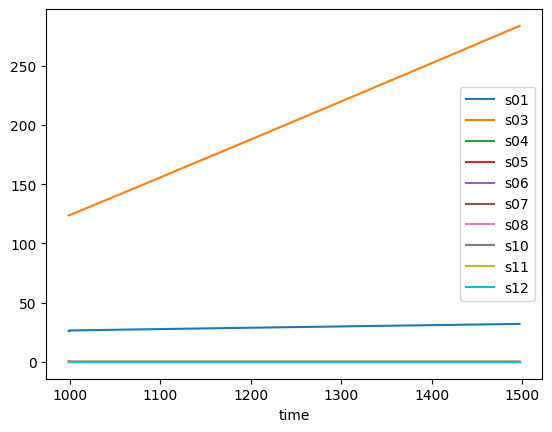

In [29]:
RN.RwDict['mak'][0]['sim'][2]['con'].plot()

There is also a simple random walk function (`setSimpleRw()`). This function, instead of calculating dynamics for each perturbation, only calculates the organizations directly below and chooses one of them at random as a convergent abstraction. Beforehand, it is necessary to calculate the synergic structure, since it allows us to know all the closed reactive ones, such as the organizations of the network.

In [30]:
# Calculation of the generators
RN.setGenerators()
# Calculation of the Closed Reactive Strucutre
RN.setSynStr()

level:  1 from  6 , node:  1  from  1
level:  2 from  6 , node:  1  from  2
level:  2 from  6 , node:  2  from  2
level:  3 from  6 , node:  1  from  1
level:  4 from  6 , node:  1  from  1
level:  6 from  6 , node:  1  from  1


24

Then we can run the Simple Random Walk, the function recives as argument the `w` keys of the dictionary of repetitions of the random walk, `l` the number of steps of the random walk, `d` is the delta value of active species increases with each pertubation in the random walk steps. `nmin` the minimal number of active species for the perturbation, and `fname` the name of the `json` file where the random walk is saved.

In [31]:
RN.setRwSimple(w=range(2),l=10,d=1,nmin=3,fname="simple_rand_walk.json")

As before we can obtain the results of the simple random walk, in the class dictionary `RwDict` under the key `simple`. The variables of the dictonary correspond to:

- `p` a dataframe the perturbed abstraction before the convergent state
- `c` a dataframe of the convergent abstraction in the random walk
- `cp` a vector of the complexity of the pertubated abstraction
- `ca` a vector of the complexity of convergent abstractions

In [32]:
RN.RwDict['simple'][0]['p']

,0,1,2,3,4,5,6,7,8,9
s01,True,True,True,True,True,True,True,True,True,True
s03,True,True,True,True,True,True,True,True,True,True
s04,True,True,True,True,True,True,True,True,True,True
s05,True,True,True,True,True,True,True,True,True,True
s06,True,True,True,True,True,True,True,True,True,True
s07,True,True,True,True,True,True,True,True,True,True
s08,True,True,True,True,True,True,True,True,True,True
s10,False,False,False,False,True,False,True,False,False,False
s11,True,True,True,True,True,True,True,True,True,True
s12,False,False,False,False,True,False,True,False,False,False


In [33]:
RN.RwDict['simple'][0]['c']

,0,1,2,3,4,5,6,7,8,9
s01,True,True,True,True,True,True,True,True,True,True
s03,True,True,True,True,True,True,True,True,True,True
s04,False,False,False,False,False,False,False,False,False,False
s05,True,True,True,True,True,True,True,True,True,True
s06,False,False,False,False,False,False,False,False,False,False
s07,False,False,False,False,False,False,False,False,False,False
s08,True,True,True,True,True,True,True,True,True,True
s10,False,False,False,False,False,False,False,False,False,False
s11,True,True,True,True,True,True,True,True,True,True
s12,False,False,False,False,False,False,False,False,False,False


In [34]:
RN.RwDict['simple'][0]['cc']

[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]

In [35]:
RN.RwDict['simple'][0]['cp']

[4.0, 4.0, 4.0, 4.0, 6.0, 4.0, 6.0, 4.0, 4.0, 4.0]